In [1]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import scipy.stats as sci
import statistics as stt
import seaborn as sns
import pandas as pd
import numpy as np
import joypy
import csv

In [2]:
dInh = {}
dNoInh = {}
num_simulations=50
for i in range(num_simulations):    
    csv_filename = '/home/roboticslab/Robotology/Repos/allostractor/data/dynamicEnv/staticQ_NoInh/' + str(i+1) + '.csv'
    dNoInh["data{0}".format(i)] = pd.read_csv(csv_filename)
    
    csv_filename = '/home/roboticslab/Robotology/Repos/allostractor/data/dynamicEnv/staticQ_Inh/' + str(i+1) + '.csv'
    dInh["data{0}".format(i)] = pd.read_csv(csv_filename)

In [3]:
simulations = len(dInh)
timesteps = dInh['data0'].shape[0]

print('Number of simulations = ' + str(simulations))
print('Number of columns = ' + str(dInh['data0'].shape[1]))
print('Number of timesteps = ' + str(timesteps))
print('Column names = ' + str(dInh['data0'].columns))

Number of simulations = 50
Number of columns = 10
Number of timesteps = 100000
Column names = Index(['Xposition', 'Yposition', 'aVtemperature', 'aVthirst', 'DriveTemp',
       'DriveThirst', 'TFtemperature', 'TFthirst', 'attractorQ', 'Grad_Temp'],
      dtype='object')


In [4]:
conditions = ['NoInh', 'Inh']
d = [dNoInh, dInh]
simulations = len(d[0])

In [5]:
aVTemp_dNoInh = dNoInh['data0']['aVtemperature'].to_list()
aVThirst_dNoInh = dNoInh['data0']['aVthirst'].to_list()

aVTemp_dInh = dInh['data0']['aVtemperature'].to_list()
aVThirst_dInh = dInh['data0']['aVthirst'].to_list()

In [6]:
aVTempConditions_mean = []
aVTempConditions_var = []
aVThirstConditions_mean = []
aVThirstConditions_var = []
GradTempConditions_mean = []

for a in range(len(conditions)):
    
    mean_slot = 1000
    aVTempSlotMean = []
    aVTempSlotVar = []
    aVThirstSlotMean = []
    aVThirstSlotVar = []
    GradTempSlotMean = []

    for i in range(int(timesteps/mean_slot)):
        SlotMean = []
        for j in range(simulations):
            dict_name = 'data'+ str(j)
            data = d[a][dict_name]['aVtemperature'][mean_slot*i:mean_slot*(i+1)]
            SlotMean.append(stt.mean(data))
        aVTempSlotMean.append(stt.mean(SlotMean))
        aVTempSlotVar.append(stt.variance(SlotMean))
    
    aVTempConditions_mean.append(aVTempSlotMean)
    aVTempConditions_var.append(aVTempSlotVar)

    

    for i in range(int(timesteps/mean_slot)):
        SlotMean = []
        for j in range(simulations):
            dict_name = 'data'+ str(j)
            data = d[a][dict_name]['aVthirst'][mean_slot*i:mean_slot*(i+1)]
            SlotMean.append(stt.mean(data))
        aVThirstSlotMean.append(stt.mean(SlotMean))
        aVThirstSlotVar.append(stt.variance(SlotMean))
        
    aVThirstConditions_mean.append(aVThirstSlotMean)
    aVThirstConditions_var.append(aVThirstSlotVar)

    
    for i in range(int(timesteps/mean_slot)):
        GradTempSlotMean.append(stt.mean(d[a][dict_name]['Grad_Temp'][mean_slot*i:mean_slot*(i+1)]))
    GradTempConditions_mean.append(GradTempSlotMean)

In [7]:
efficiency_conditions = []
for a in range(len(conditions)):
    efficiency = []
    for i in range(len(aVTempConditions_mean[a])):
        efficiency.append((aVTempConditions_mean[a][i] + aVThirstConditions_mean[a][i])/2)
        
    efficiency_conditions.append(efficiency)

In [8]:
fairness_conditions = []
for a in range(len(conditions)):
    fairness = []
    for i in range(len(aVTempConditions_mean[a])):
        fairness.append(1 - abs(aVTempConditions_mean[a][i]-aVThirstConditions_mean[a][i]))
        
    fairness_conditions.append(fairness)

In [9]:
stability_conditions = []

aVs_ts_conditions = []
dVs_ts_conditions = []

for a in range(len(conditions)):
    stability = []
    aVs_timestep = []
    dVs_timestep = []
    
    
    for i in range(len(aVTempConditions_mean[a])):
        current_timestep = []
        current_timestep.append(aVTempConditions_mean[a][i])
        current_timestep.append(aVThirstConditions_mean[a][i])
        aVs_timestep.append(current_timestep)
        dVs_timestep.append([1, 1])
        
    aVs_ts_conditions.append(aVs_timestep)
    dVs_ts_conditions.append(dVs_timestep)


    for i in range(len(aVs_ts_conditions[a])):
        stability.append(1-np.mean((np.array(dVs_ts_conditions[a][i]) - np.array(aVs_ts_conditions[a][i]))**2))
        
    stability_conditions.append(stability)

In [10]:
cond_colum = (['No Inhibition'] * 100 + ['Inhibition'] * 100)*5
Temp_aV_means = aVTempConditions_mean[0] + aVTempConditions_mean[1]
Hydr_aV_means = aVThirstConditions_mean[0] + aVThirstConditions_mean[1]
efficiency = efficiency_conditions[0] + efficiency_conditions[1]
fairness = fairness_conditions[0] + fairness_conditions[1]
stability = stability_conditions[0] + stability_conditions[1]
Measure = ['Temperature'] * 200 + ['Hydration'] * 200 + ['Efficiency'] * 200 + ['Fairness'] * 200 + ['Stability'] * 200
Values = Temp_aV_means + Hydr_aV_means + efficiency + fairness + stability

In [11]:
d = {'Conditions': cond_colum, ' ': Values, 'Measure': Measure}
df = pd.DataFrame(data=d)

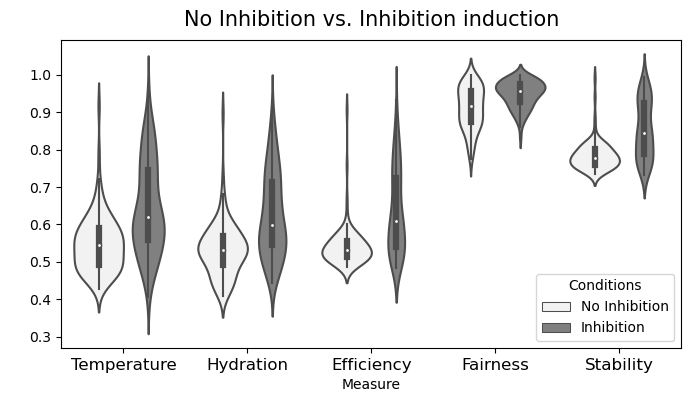

In [28]:
fig = plt.figure(figsize=(8, 4))
my_pal = {"versicolor": "g", "setosa": "b", "virginica": "m"}
ax = sns.violinplot(x="Measure", y=" ", hue="Conditions", data=df, color='Gray')
ax.set_xticklabels(['Temperature', 'Hydration', 'Efficiency', 'Fairness', 'Stability'], rotation = 0, ha="center", fontsize = 12)
plt.title('No Inhibition vs. Inhibition induction', fontsize = 15, pad=10)
plt.show()
fig.savefig('/home/roboticslab/Robotology/Repos/allostractor/Plots/NoInh_Inh/Measures.pdf', format='pdf', bbox_inches='tight')

In [13]:
if sci.normaltest(aVTempConditions_mean[0])[1] < 0.05:
    print("aVTempConditions_mean[0] distribution is NON-NORMAL with p = " + str(sci.normaltest(aVTempConditions_mean[0])[1]))
else:
    print("aVTempConditions_mean[0] distribution is Normal")
    
if sci.normaltest(aVTempConditions_mean[1])[1] < 0.05:
    print("aVTempConditions_mean[1] distribution is NON-NORMAL with p = " + str(sci.normaltest(aVTempConditions_mean[1])[1]))
else:
    print("aVTempConditions_mean[1] distribution is Normal")
    
if sci.normaltest(aVThirstConditions_mean[0])[1] < 0.05:
    print("aVThirstConditions_mean[0] distribution is NON-NORMAL with p = " + str(sci.normaltest(aVThirstConditions_mean[0])[1]))
else:
    print("aVThirstConditions_mean[0] distribution is Normal")
    
if sci.normaltest(aVThirstConditions_mean[1])[1] < 0.05:
    print("aVThirstConditions_mean[1] distribution is NON-NORMAL with p = " + str(sci.normaltest(aVThirstConditions_mean[1])[1]))
else:
    print("aVThirstConditions_mean[1] distribution is Normal")
    
if sci.normaltest(efficiency_conditions[0])[1] < 0.05:
    print("efficiency_conditions[0] distribution is NON-NORMAL with p = " + str(sci.normaltest(efficiency_conditions[0])[1]))
else:
    print("efficiency_conditions[0] distribution is Normal")

if sci.normaltest(efficiency_conditions[1])[1] < 0.05:
    print("efficiency_conditions[1] distribution is NON-NORMAL with p = " + str(sci.normaltest(efficiency_conditions[1])[1]))
else:
    print("efficiency_conditions[1] distribution is Normal")

if sci.normaltest(fairness_conditions[0])[1] < 0.05:
    print("fairness_conditions[0] distribution is NON-NORMAL with p = " + str(sci.normaltest(fairness_conditions[0])[1]))
else:
    print("fairness_conditions[0] distribution is Normal")

if sci.normaltest(fairness_conditions[1])[1] < 0.05:
    print("fairness_conditions[1] distribution is NON-NORMAL with p = " + str(sci.normaltest(fairness_conditions[0])[1]))
else:
    print("fairness_conditions[1] distribution is Normal")

if sci.normaltest(stability_conditions[0])[1] < 0.05:
    print("stability_conditions[0] distribution is NON-NORMAL with p = " + str(sci.normaltest(stability_conditions[0])[1]))
else:
    print("stability_conditions[0] distribution is Normal")

if sci.normaltest(stability_conditions[1])[1] < 0.05:
    print("stability_conditions[1] distribution is NON-NORMAL with p = " + str(sci.normaltest(stability_conditions[1])[1]))
else:
    print("stability_conditions[1] distribution is Normal")

if sci.normaltest(GradTempConditions_mean[0])[1] < 0.05:
    print("GradTempConditions_mean[0] distribution is NON-NORMAL with p = " + str(sci.normaltest(GradTempConditions_mean[0])[1]))
else:
    print("GradTempConditions_mean[0] distribution is Normal")

aVTempConditions_mean[0] distribution is NON-NORMAL with p = 8.359545393186825e-10
aVTempConditions_mean[1] distribution is NON-NORMAL with p = 0.0342327947130797
aVThirstConditions_mean[0] distribution is NON-NORMAL with p = 5.720334342709794e-10
aVThirstConditions_mean[1] distribution is NON-NORMAL with p = 0.02161867952060766
efficiency_conditions[0] distribution is NON-NORMAL with p = 4.843108081212317e-27
efficiency_conditions[1] distribution is NON-NORMAL with p = 0.0057627437782405986
fairness_conditions[0] distribution is NON-NORMAL with p = 0.04346706634788617
fairness_conditions[1] distribution is NON-NORMAL with p = 0.04346706634788617
stability_conditions[0] distribution is NON-NORMAL with p = 3.878972516797451e-17
stability_conditions[1] distribution is NON-NORMAL with p = 1.1896196985241144e-10
GradTempConditions_mean[0] distribution is NON-NORMAL with p = 4.96038579365656e-08


In [14]:
No_Inh_Temp_corr = round(sci.spearmanr(aVTempConditions_mean[0], GradTempConditions_mean[0])[0],2)
No_Inh_Hydr_corr = round(sci.spearmanr(aVThirstConditions_mean[0], GradTempConditions_mean[0])[0],2)
No_Inh_Eff_corr = round(sci.spearmanr(efficiency_conditions[0], GradTempConditions_mean[0])[0],2)
No_Inh_Fair_corr = round(sci.spearmanr(fairness_conditions[0], GradTempConditions_mean[0])[0],2)
No_Inh_Stab_corr = round(sci.spearmanr(stability_conditions[0], GradTempConditions_mean[0])[0],2)
Inh_Temp_corr = round(sci.spearmanr(aVTempConditions_mean[1], GradTempConditions_mean[0])[0],2)
Inh_Hydr_corr = round(sci.spearmanr(aVThirstConditions_mean[1], GradTempConditions_mean[0])[0],2)
Inh_Eff_corr = round(sci.spearmanr(efficiency_conditions[1], GradTempConditions_mean[0])[0],2)
Inh_Fair_corr = round(sci.spearmanr(fairness_conditions[1], GradTempConditions_mean[0])[0],2)
Inh_Stab_corr = round(sci.spearmanr(stability_conditions[1], GradTempConditions_mean[0])[0],2)

print(No_Inh_Temp_corr)
print(No_Inh_Hydr_corr)
print(No_Inh_Eff_corr)
print(No_Inh_Fair_corr)
print(No_Inh_Stab_corr)
print()
print(Inh_Temp_corr)
print(Inh_Hydr_corr)
print(Inh_Eff_corr)
print(Inh_Fair_corr)
print(Inh_Stab_corr)

0.48
0.44
0.97
-0.02
0.97

0.95
0.94
1.0
0.32
1.0


In [15]:
corr_data = np.array([[No_Inh_Temp_corr, No_Inh_Hydr_corr, No_Inh_Eff_corr, No_Inh_Fair_corr, No_Inh_Stab_corr],
                     [Inh_Temp_corr, Inh_Hydr_corr, Inh_Eff_corr, Inh_Fair_corr, Inh_Stab_corr]])

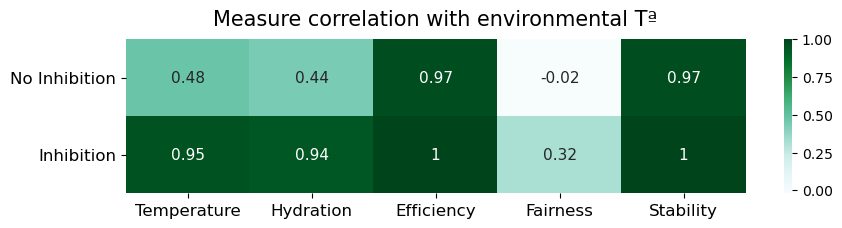

In [16]:
fig = plt.figure(figsize=(10, 2))
ax = sns.heatmap(corr_data, annot=True, cmap="BuGn", annot_kws={"fontsize":11})
ax.set_yticklabels(['No Inhibition', 'Inhibition'], rotation = 0, ha="right", fontsize = 12)
ax.set_xticklabels(['Temperature', 'Hydration', 'Efficiency', 'Fairness', 'Stability'], rotation = 0, ha="center", fontsize = 12)
plt.title('Measure correlation with environmental Tª', fontsize = 15, pad=10)
plt.show()
fig.savefig('/home/roboticslab/Robotology/Repos/allostractor/Plots/NoInh_Inh/Correlations.pdf', format='pdf', bbox_inches='tight')

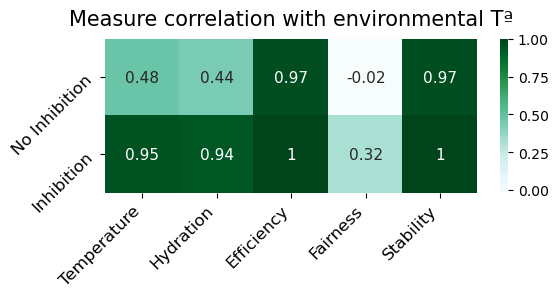

In [17]:
fig = plt.figure(figsize=(6, 2))
ax = sns.heatmap(corr_data, annot=True, cmap="BuGn", annot_kws={"fontsize":11})
ax.set_yticklabels(['No Inhibition', 'Inhibition'], rotation = 45, ha="right", fontsize = 12)
ax.set_xticklabels(['Temperature', 'Hydration', 'Efficiency', 'Fairness', 'Stability'], rotation = 45, ha="right", fontsize = 12)
plt.title('Measure correlation with environmental Tª', fontsize = 15, pad=10)
plt.show()
fig.savefig('/home/roboticslab/Robotology/Repos/allostractor/Plots/NoInh_Inh/Correlations2.pdf', format='pdf', bbox_inches='tight')

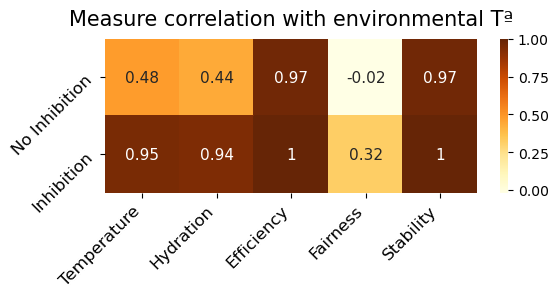

In [18]:
fig = plt.figure(figsize=(6, 2))
ax = sns.heatmap(corr_data, annot=True, cmap="YlOrBr", annot_kws={"fontsize":11})
ax.set_yticklabels(['No Inhibition', 'Inhibition'], rotation = 45, ha="right", fontsize = 12)
ax.set_xticklabels(['Temperature', 'Hydration', 'Efficiency', 'Fairness', 'Stability'], rotation = 45, ha="right", fontsize = 12)
plt.title('Measure correlation with environmental Tª', fontsize = 15, pad=10)
plt.show()
fig.savefig('/home/roboticslab/Robotology/Repos/allostractor/Plots/NoInh_Inh/Correlations3.pdf', format='pdf', bbox_inches='tight')